#Transfer Learning for NLP: Fine-Tuning BERT for Text Classification(yelp reviews rating prediction)

##Good articles for better understand BERT model:

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

* [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)

* [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#4-train-our-classification-model)

##Set up

In [1]:
!pip install transformers
pass

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Take a look at the category of data

* loading the processed data

In [ ]:
path = '/content/drive/My Drive/NLP/data/EnglishTextReviews.csv'
df = pd.read_csv(path)
df.head()

* Distributions of Data

In [ ]:
df.stars.fillna('NaN')

In [ ]:
df.groupby(['stars']).count()

* Visualizing distributions of Data

In [ ]:
df['stars'].value_counts().plot(kind='bar')

##Spliting the dataset

In [ ]:
#get a sample of 20000 from the dataset of 500000+
sample_df = df.sample(n=18000, random_state=1)

In [ ]:
sample_df['stars'] = sample_df['stars'].astype(int)-1

In [ ]:
sample_df.groupby(['stars']).count()

In [ ]:
sample_df['stars'].value_counts().plot(kind='bar')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    sample_df.text.values,
    sample_df.stars.values,
    test_size = 0.15,
    random_state = 17,#guarantee that your split will be always the same.
    stratify = sample_df.stars.values 
)

In [ ]:
pd.Series(y_val).hist()

In [ ]:
pd.Series(y_val).hist()

##Creating a bert tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

##Tokenize the Sentences

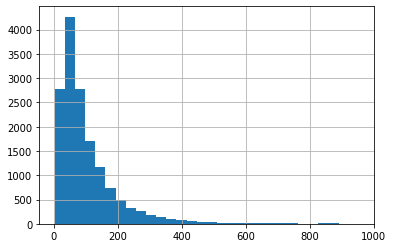

In [18]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in x_train]

pd.Series(seq_len).hist(bins = 30)

* Most texts have words less than 250, then set the max_length=250

In [19]:
encoded_train = tokenizer.batch_encode_plus(
    x_train,
    add_special_tokens = True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=200,
    return_tensors='pt'
)

encoded_val = tokenizer.batch_encode_plus(
    x_val,
    add_special_tokens = True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=200,
    return_tensors='pt'
)

ids_train = encoded_train['input_ids']
attention_masks_train = encoded_train['attention_mask']
labels_train = torch.tensor(y_train)

ids_val = encoded_val['input_ids']
attention_masks_val = encoded_val['attention_mask']
labels_val = torch.tensor(y_val)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitely activated but `max_length` is provided a specific value, please use

In [20]:
dataset_train = TensorDataset(
    ids_train,
    attention_masks_train,
    labels_train
)

dataset_val = TensorDataset(
    ids_val,
    attention_masks_val,
    labels_val
)

###How does the tokenized sentence look like?

In [21]:
x_train[1]

"Very responsive, great attention to detail, and fair price. Inspector paid close attention to every detail of our new-construction home and called out many cosmetic defects that we probably wouldn't have caught on our own. Luckily no major structural, electrical, or mechanical issues were identified, but peace of mind is worth the cost. Well worth the money to ensure our new home is in the condition it should be when we move in."

In [22]:
ids_train[1]

tensor([  101,  2200, 26651,  1010,  2307,  3086,  2000,  6987,  1010,  1998,
         4189,  3976,  1012,  7742,  3825,  2485,  3086,  2000,  2296,  6987,
         1997,  2256,  2047,  1011,  2810,  2188,  1998,  2170,  2041,  2116,
        25536, 18419,  2008,  2057,  2763,  2876,  1005,  1056,  2031,  3236,
         2006,  2256,  2219,  1012, 15798,  2053,  2350,  8332,  1010,  5992,
         1010,  2030,  6228,  3314,  2020,  4453,  1010,  2021,  3521,  1997,
         2568,  2003,  4276,  1996,  3465,  1012,  2092,  4276,  1996,  2769,
         2000,  5676,  2256,  2047,  2188,  2003,  1999,  1996,  4650,  2009,
         2323,  2022,  2043,  2057,  2693,  1999,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [23]:
attention_masks_train[1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
labels_train[1]

tensor(4)

##Creating Data Loaders

In [28]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [29]:
batch_size = 32

dataloader_train = DataLoader(
    dataset_train,
    sampler = RandomSampler(dataset_train),
    batch_size = batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler = RandomSampler(dataset_val),
    batch_size = batch_size
)

## Setting up BERT Pretrained Model

In [30]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(sample_df.stars.unique()),
    output_attentions = False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Setting Up Optimizer and Scheduler

In [31]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [32]:
optimizer = AdamW(
    model.parameters(),
    lr=2e-6,
    eps= 1e-8 #Adam's epsilon for numerical stability
)

In [33]:
epochs = 20

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps =0,
    num_training_steps = len(dataloader_train)*epochs,

)

## Defining our Performance Metrics

* The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. 

* $F1 = 2 * \frac{precision * recall}{precision + recall}$, where $precision = \frac{true positive}{total predicted positive}$, $recall = \frac{true positive}{total actual positive}$

In [34]:
from sklearn.metrics import f1_score

In [35]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [36]:
labels_dic = {i:i for i in range(0,5)}
def accuracy_per_class(preds, labels):

    label_dict_inverse = {v: k for k, v in labels_dic.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print("Overall Accuracy:", np.sum([preds_flat==labels_flat])/len(labels_flat))
    print()

    for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat == label]
      y_true = labels_flat[labels_flat == label]
      print(f'Class: {label_dict_inverse[label]}')
      print(f'Accuracy: {len(y_preds[y_preds == label])/len(y_true)}\n')

## Creating the Training Loop

In [ ]:
from tqdm.notebook import tqdm
import random

seed_val = 10
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0, norm_type=2)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

##Loading and Evaluating our Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 5,
    output_attentions = False,
    output_hidden_states=False
)

In [ ]:
model.to(device)
pass

In [ ]:
model.load_state_dict(
    torch.load('finetuned_BERT_epoch_5.model',
                      map_location=torch.device('cpu'))) #put the device back to cpu

In [ ]:
_, predictions, true_vals = evaluate(dataloader_val)

In [ ]:
accuracy_per_class(predictions, true_vals)